In [1]:
# Since the best way to learn/hack on Dask seems to be by directly editing the installed source code,
# let's have it all reloaded automatically.
#

%load_ext autoreload
%aimport -dask.utils

%autoreload 2

In [2]:
# To set up an environment for this experiment, run:
#    mamba create -n lsd2-2023 -c conda-forge dask pyarrow healpy ipykernel python-graphviz rich ipywidgets python-snappy
# and then create a Jupyter kernel w. something like:
#    conda activate lsd2-2023
#    python -m ipykernel install --user --name lsd2-2023 --display-name "LSD2 (2023)"
#

import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np
import healpy as hp

import lsdb
import hipscat as hc

print(f"{dask.__version__=}")
print(f"{pd.__version__=}")
print(f"{np.__version__=}")
print(f"{hp.__version__=}")
print(f"{lsdb.__version__=}")
print(f"{hc.__version__=}")


dask.__version__='2022.12.1'
pd.__version__='1.5.2'
np.__version__='1.24.0'
hp.__version__='1.16.1'
lsdb.__version__='0.0.1dev'
hc.__version__='0.0.1dev'


Configure Dask:

In [3]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

dask.config.set(temporary_directory='/epyc/ssd/users/mjuric/tmp')
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

# try to silence incredibly annoying INFO/WARN gc messages (alas, doesn't seem to work...)
# FIXME: follow https://dask.discourse.group/t/disable-dask-worker-logs-from-printing-on-console-and-write-to-file/408/4
#  to implement a more fine-grained solution
dask.config.set({'logging.distributed': 'error'});

In [4]:
import glob

inprefix = "/epyc/projects3/sam_hipscat/output/gaia_real"
outprefix = "/epyc/projects3/mjuric_hipscat/foo"

Launch Dask cluster:

In [5]:
from dask.distributed import Client
client = Client(n_workers=48, threads_per_worker=1, memory_limit="24G", dashboard_address="localhost:23456")

port = client._get_scheduler_info()[1]["services"]["dashboard"]
print("Tunnel SSH command:")
print(f"ssh -L {port}:localhost:{port} epyc.astro.washington.edu")

client

Tunnel SSH command:
ssh -L 23456:localhost:23456 epyc.astro.washington.edu


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:23456/status,
Dashboard: http://127.0.0.1:23456/status,Workers: 48
Total threads: 48,Total memory: 1.05 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40987,Workers: 48
Dashboard: http://127.0.0.1:23456/status,Total threads: 48
Started: Just now,Total memory: 1.05 TiB
Comm: tcp://127.0.0.1:42588,Total threads: 1
Dashboard: http://127.0.0.1:42068/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:40991,


Import a HiPSCat catalog from a list files. These can be in any format that Dask knows how to read. Assumes the spatial columsn are named "ra" and "dec".

In [8]:
%%time
! rm -fr "{outprefix}"-test

# Input dataframe
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')[:5]
ddf = dd.read_parquet(incat)

# Convert to HiPSCat
ldf = lsdb.from_dask(ddf)
_ = ldf.to_hipscat(f"{outprefix}-test"); # _ = ... is there just to suppress output.

CPU times: user 9.86 s, sys: 5.95 s, total: 15.8 s
Wall time: 31 s


Same as the above, but here we're giving the importer a separate dataframe for skymap computation.
This comes in handy when reading from large, column-oriented, inputs (such as parquet), where we can avoid loading all columns just to compute the skymap (thus making it faster).
Too bad dask doesn't have an optimizer to automatically cull columns (like Spark's Catalyst)

In [9]:
%%time
! rm -fr "{outprefix}"-test

# Input dataframe
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')[:5]
counts_df = dd.read_parquet(incat, columns=["ra", "dec"])
cat_df    = dd.read_parquet(incat)

# Convert to hipscat
ldf = lsdb.from_dask(cat_df, counts_df=counts_df)
_ = ldf.to_hipscat(f"{outprefix}-test");

CPU times: user 11.1 s, sys: 5.54 s, total: 16.6 s
Wall time: 25.1 s


Now import from CSV, the complete catalog:

In [10]:
%%time

# This can take some ~5hrs & isn't to be re-run lightly.
# I wrapped it into "if False" after rerunning it one-too-many times....
# the output is also sizable (lots of dask errors, but it still manages t
# finish correctly -- see dask-gaia-import-errors.txt for an example).
if False:
    ! rm -fr "{outprefix}"

    gaiacsv = glob.glob("/epyc/data/gaia_dr3/csv/GaiaSource/GaiaSource_*.csv.gz")

    # FIXME: this is very brittle. column datatypes should be loaded from Gaia's CSV header (or elsewhere).
    # also see https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options
    ddf = dd.read_csv(gaiacsv, comment="#", blocksize=None,
                      dtype={   'phot_bp_n_blended_transits':      'float64',
                                'phot_bp_n_contaminated_transits': 'float64',
                                'phot_rp_n_blended_transits':      'float64',
                                'phot_rp_n_contaminated_transits': 'float64',
                                'phot_proc_mode':                  'float64'
                            })
    ldf = lsdb.from_dask(ddf)
    _ = ldf.to_hipscat(outprefix);

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 37.9 µs


That the above works is important -- it means that any format that can be loaded into a dask.dataframe can be converted to HiPSCat with just `lsdb.from_dask(ddf).to_hipscat(prefix)`. And since dask supports reading of everything Pandas supports, we basically cover all formats out there (parquet, CSV, HDF5, ...), except for FITS tables.

We still need to have some UI for the user to specify column names, datatypes, etc., but that's much less code and likely be made generic/confgurable ([like in LSD1](https://github.com/mjuric/lsd/blob/master/src/lsd-import)).

Now let's load from hipscat and have some "data analysis" fun:

In [11]:
ldf = lsdb.read_hipscat(outprefix, columns=["ra", "dec", "source_id", "parallax"])

Full sky map, for a basic sanity check:

CPU times: user 18.6 s, sys: 7.75 s, total: 26.3 s
Wall time: 29.9 s


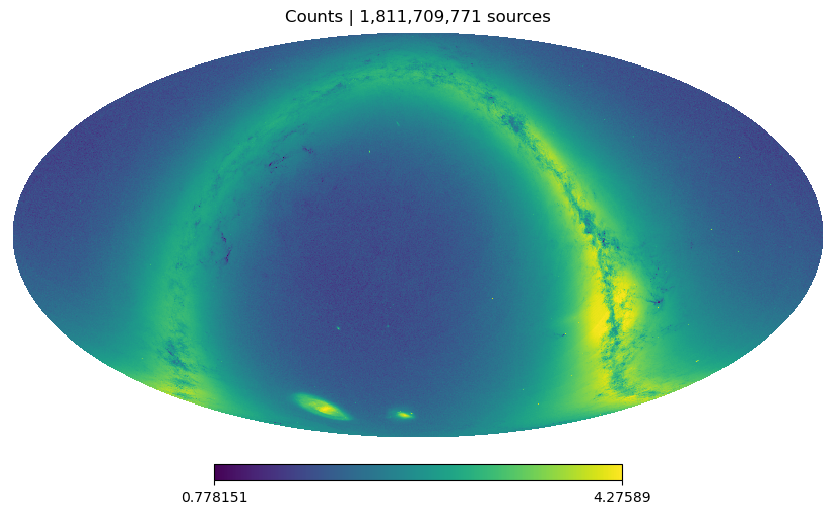

In [13]:
%%time
m = lsdb.compute_skymap(ldf)
hp.mollview(np.log10(m+1), title=f'Counts | {m.sum():,.0f} sources', nest=True)

Plot a mollview of a simple query. Demonstrates method chaining works properly, and how easy it is to build sky maps. We should probably also have a method version of `lsdb.compute_skymap`.

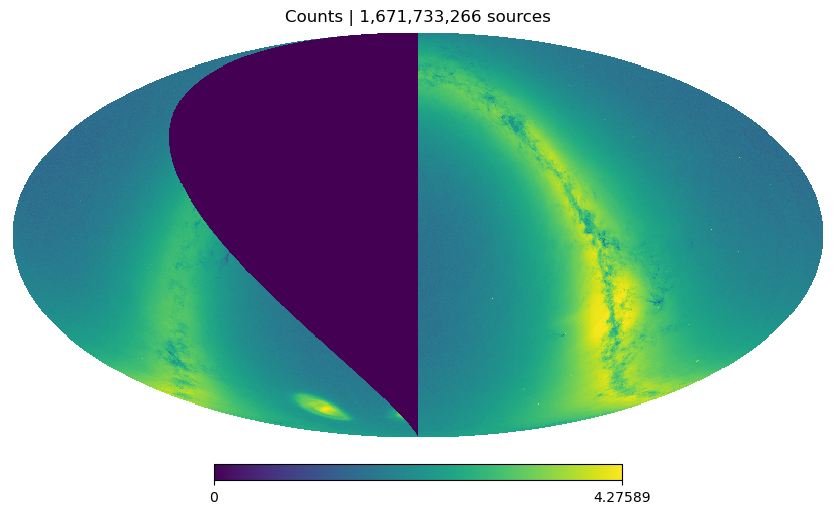

In [12]:
m = ldf.query("abs(ra - dec) > 90").pipe(lsdb.compute_skymap)
hp.mollview(np.log10(m+1), title=f'Counts | {m.sum():,.0f} sources', nest=True)

Let's test a common usecase where a user subsets a larger dataset and saves it to a table for future use:

In [14]:
! rm -rf "{outprefix}"-coords

# select a subset of columns and store to a new HiPSCat table
ldf = lsdb.read_hipscat(outprefix, columns=["ra", "dec", "source_id", "parallax"])
ldf[["ra", "dec"]].query("dec > 10").to_hipscat(f"{outprefix}-coords");

Now let's verify this worked by rereading and plotting a skymap:

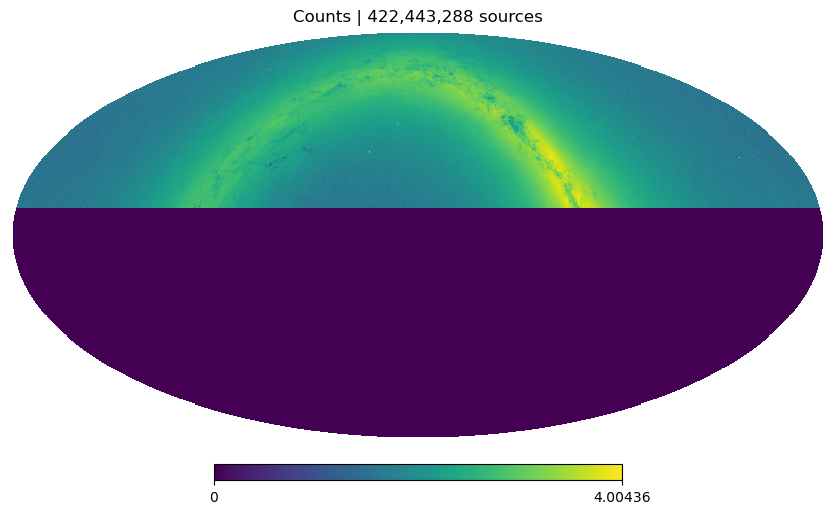

In [15]:
ldf = lsdb.read_hipscat(f"{outprefix}-coords")
m = lsdb.compute_skymap(ldf)
hp.mollview(np.log10(m+1), title=f'Counts | {m.sum():,.0f} sources', nest=True)

## Musings about the next steps

* Big realization: catalogs tend to have a huge number of columns. This drives to large row sizes (in bytes), which drives our choice of objects-per-partition to keep each partition fitting into RAM. That leads to a large number of partitions (e.g. \~4k for Gaia). However, only \~10-20 columns are frequently used for science work; if the catalog consisted of only those columns, the number of partitions would be _dramatically_ lower (\~10x), leading to factor-of-few speed-ups on workloads that are I/O heavy (where the overhead of touching each file is the dominant factor). We should therefore also _vertically_ partition the catalog! E.g., have the commonly used columns (or columns that are frequently used together) in one HiPSCat hierarchy, others in another, etc. This can be realized as just a set of HiPSCat tables, but we could also support this within _one_ HiPSCat table. This deserves more thought/discussion.
* `lsdb.read_hipscat()` that by default reads every column in the catalog will drive the users to write inefficient pipes (as dask isn't clever enough to analyze the execution graph and cull unneeded columns). We should instead only expose/advertise something like `lsdb.select(... list of columns ...")` API. This will be familiar to the users (select is SQL-ish) and will lead them to more performant pipelines.
* When catalogs are subset and saved, their original partitioning is kept. If the subsetting was very selective, this will generate tiny partitions and be inefficient. We should add an `ldf.repartition()` that reoptimizes the partitioning. This should be fairly straightforward, the biggest problem is the semantics of that API -- it (annoyingly) can't be delayed, and somehow we need to make it unsurprising to the users.
* Integrating lessons learned & the code into the main repo!

## Various Unit-ish tests

Probably not worth looking unless you're trying to understand what a specific function does.

### Pixel-wrangling functions

In [10]:
# test computing the hcidx
import hipscat as hc

try:
    df_orig
except NameError:
    df_orig = pd.read_parquet(f'{inprefix}/Norder2/Npix65/catalog.parquet')
dff = df_orig.copy().iloc[:5]
dff["_ID"] = hc.compute_hcidx(dff["ra"].values, dff["dec"].values)
dff.set_index("_ID", inplace=True)
dff.sort_index(inplace=True)

dff.iloc[:10][["ra", "dec"]]

,ra,dec
_ID,,
4683743707272314880,11.264255,-29.980008
4683743729093181440,11.255093,-29.976936
4683743968771440640,11.280663,-29.960359
4737483338421370880,4.655083,-15.329481
4753396986173980672,13.173931,-11.254662


Partitioning function

3145728


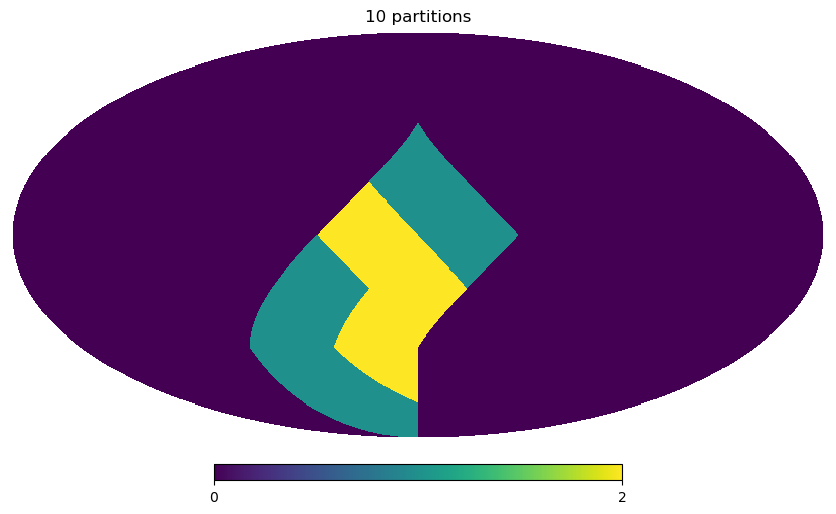

In [13]:
m = np.load("/epyc/projects3/mjuric_hipscat/counts.npy")

opix, orders = hc.compute_partitioning(m)
assert opix[0].dtype == np.uint64

nparts = sum(map(len, opix.values()))
hp.mollview(orders, title=f'{nparts:,.0f} partitions', nest=True)
print(len(orders))

Test the conversion of MOC to orders map

192


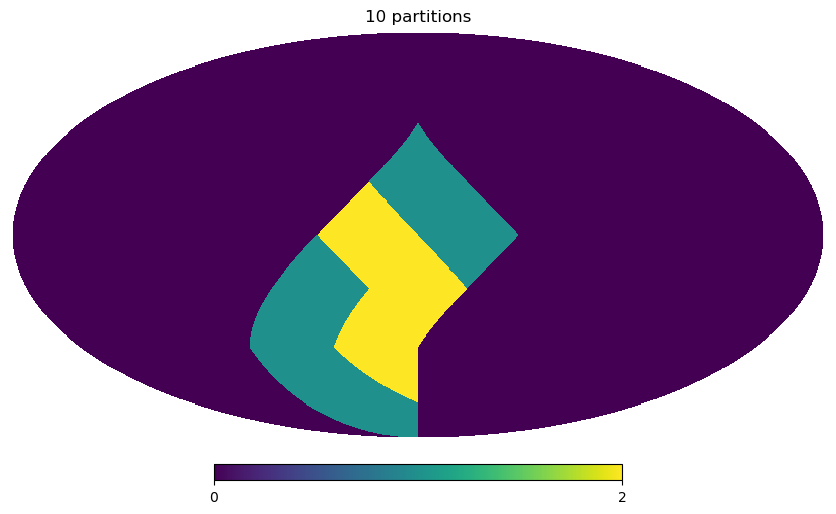

In [14]:
mm = hc.moc2orders(opix)
print(len(mm))
nparts = sum(map(len, opix.values()))
hp.mollview(mm, title=f'{nparts:,.0f} partitions', nest=True)

Test that binning of ra/dec to maps works

In [16]:
df = pd.read_parquet(f'{inprefix}/Norder2/Npix65/catalog.parquet', columns=["ra", "dec"])
m = hc.counts_histogram(df["ra"].values, df["dec"].values, 10)
print(len(m))

12582912


Test building the counts map from a dask dataframe

[########################################] | 100% Completed | 530.05 ms
[########################################] | 100% Completed | 531.11 ms
3145728


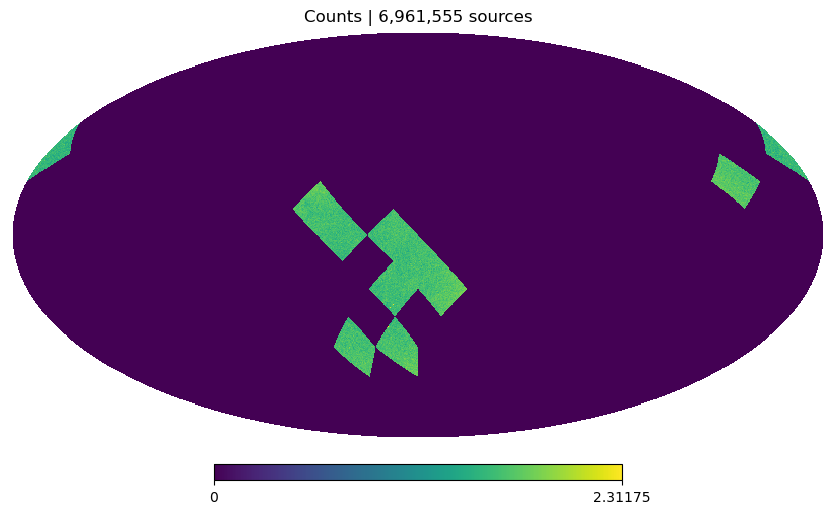

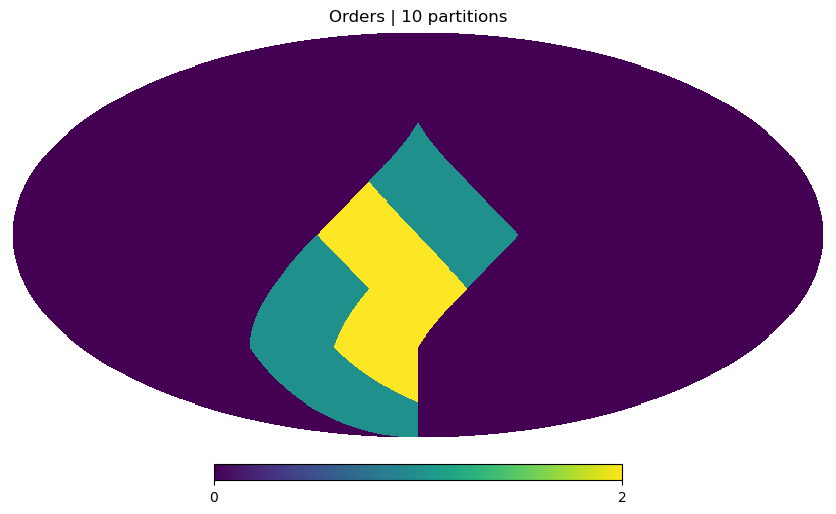

In [19]:
import lsdb

incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')
ddf = dd.read_parquet(incat[:10], columns=["ra", "dec"])

m = lsdb.compute_skymap(ddf, compute=True)
opix, orders = hc.compute_partitioning(m)

if True:
    print(len(m))
    hp.mollview(np.log10(m+1), title=f'Counts | {m.sum():,.0f} sources', nest=True)

if True:
    nparts = sum(map(len, opix.values()))
    hp.mollview(orders, title=f'Orders | {nparts:,.0f} partitions', nest=True)

if True:
    np.save("/epyc/projects3/mjuric_hipscat/counts.npy", m)

Test HCMetadata class:

In [20]:
hcmeta = hc.HCMetadata.from_skymap(m)
print(hcmeta)
print(repr(hcmeta.compute_divisions()))

{'opix': {0: array([0, 2, 6], dtype=uint64), 2: array([ 65,  66,  67,  69,  70, 137, 138], dtype=uint64)}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}
array([                   0,  2305843009213693952,  4683743612465315840,
        4755801206503243776,  4827858800541171712,  4971973988617027584,
        5044031582654955520,  691

Test conversion from parquet to hipscat:

[0, 2305843009213693952, 4683743612465315840, 4755801206503243776, 4827858800541171712, 4971973988617027584, 5044031582654955520, 6917529027641081856, 9871890383196127232, 9943947977234055168, 18446744073709551615]


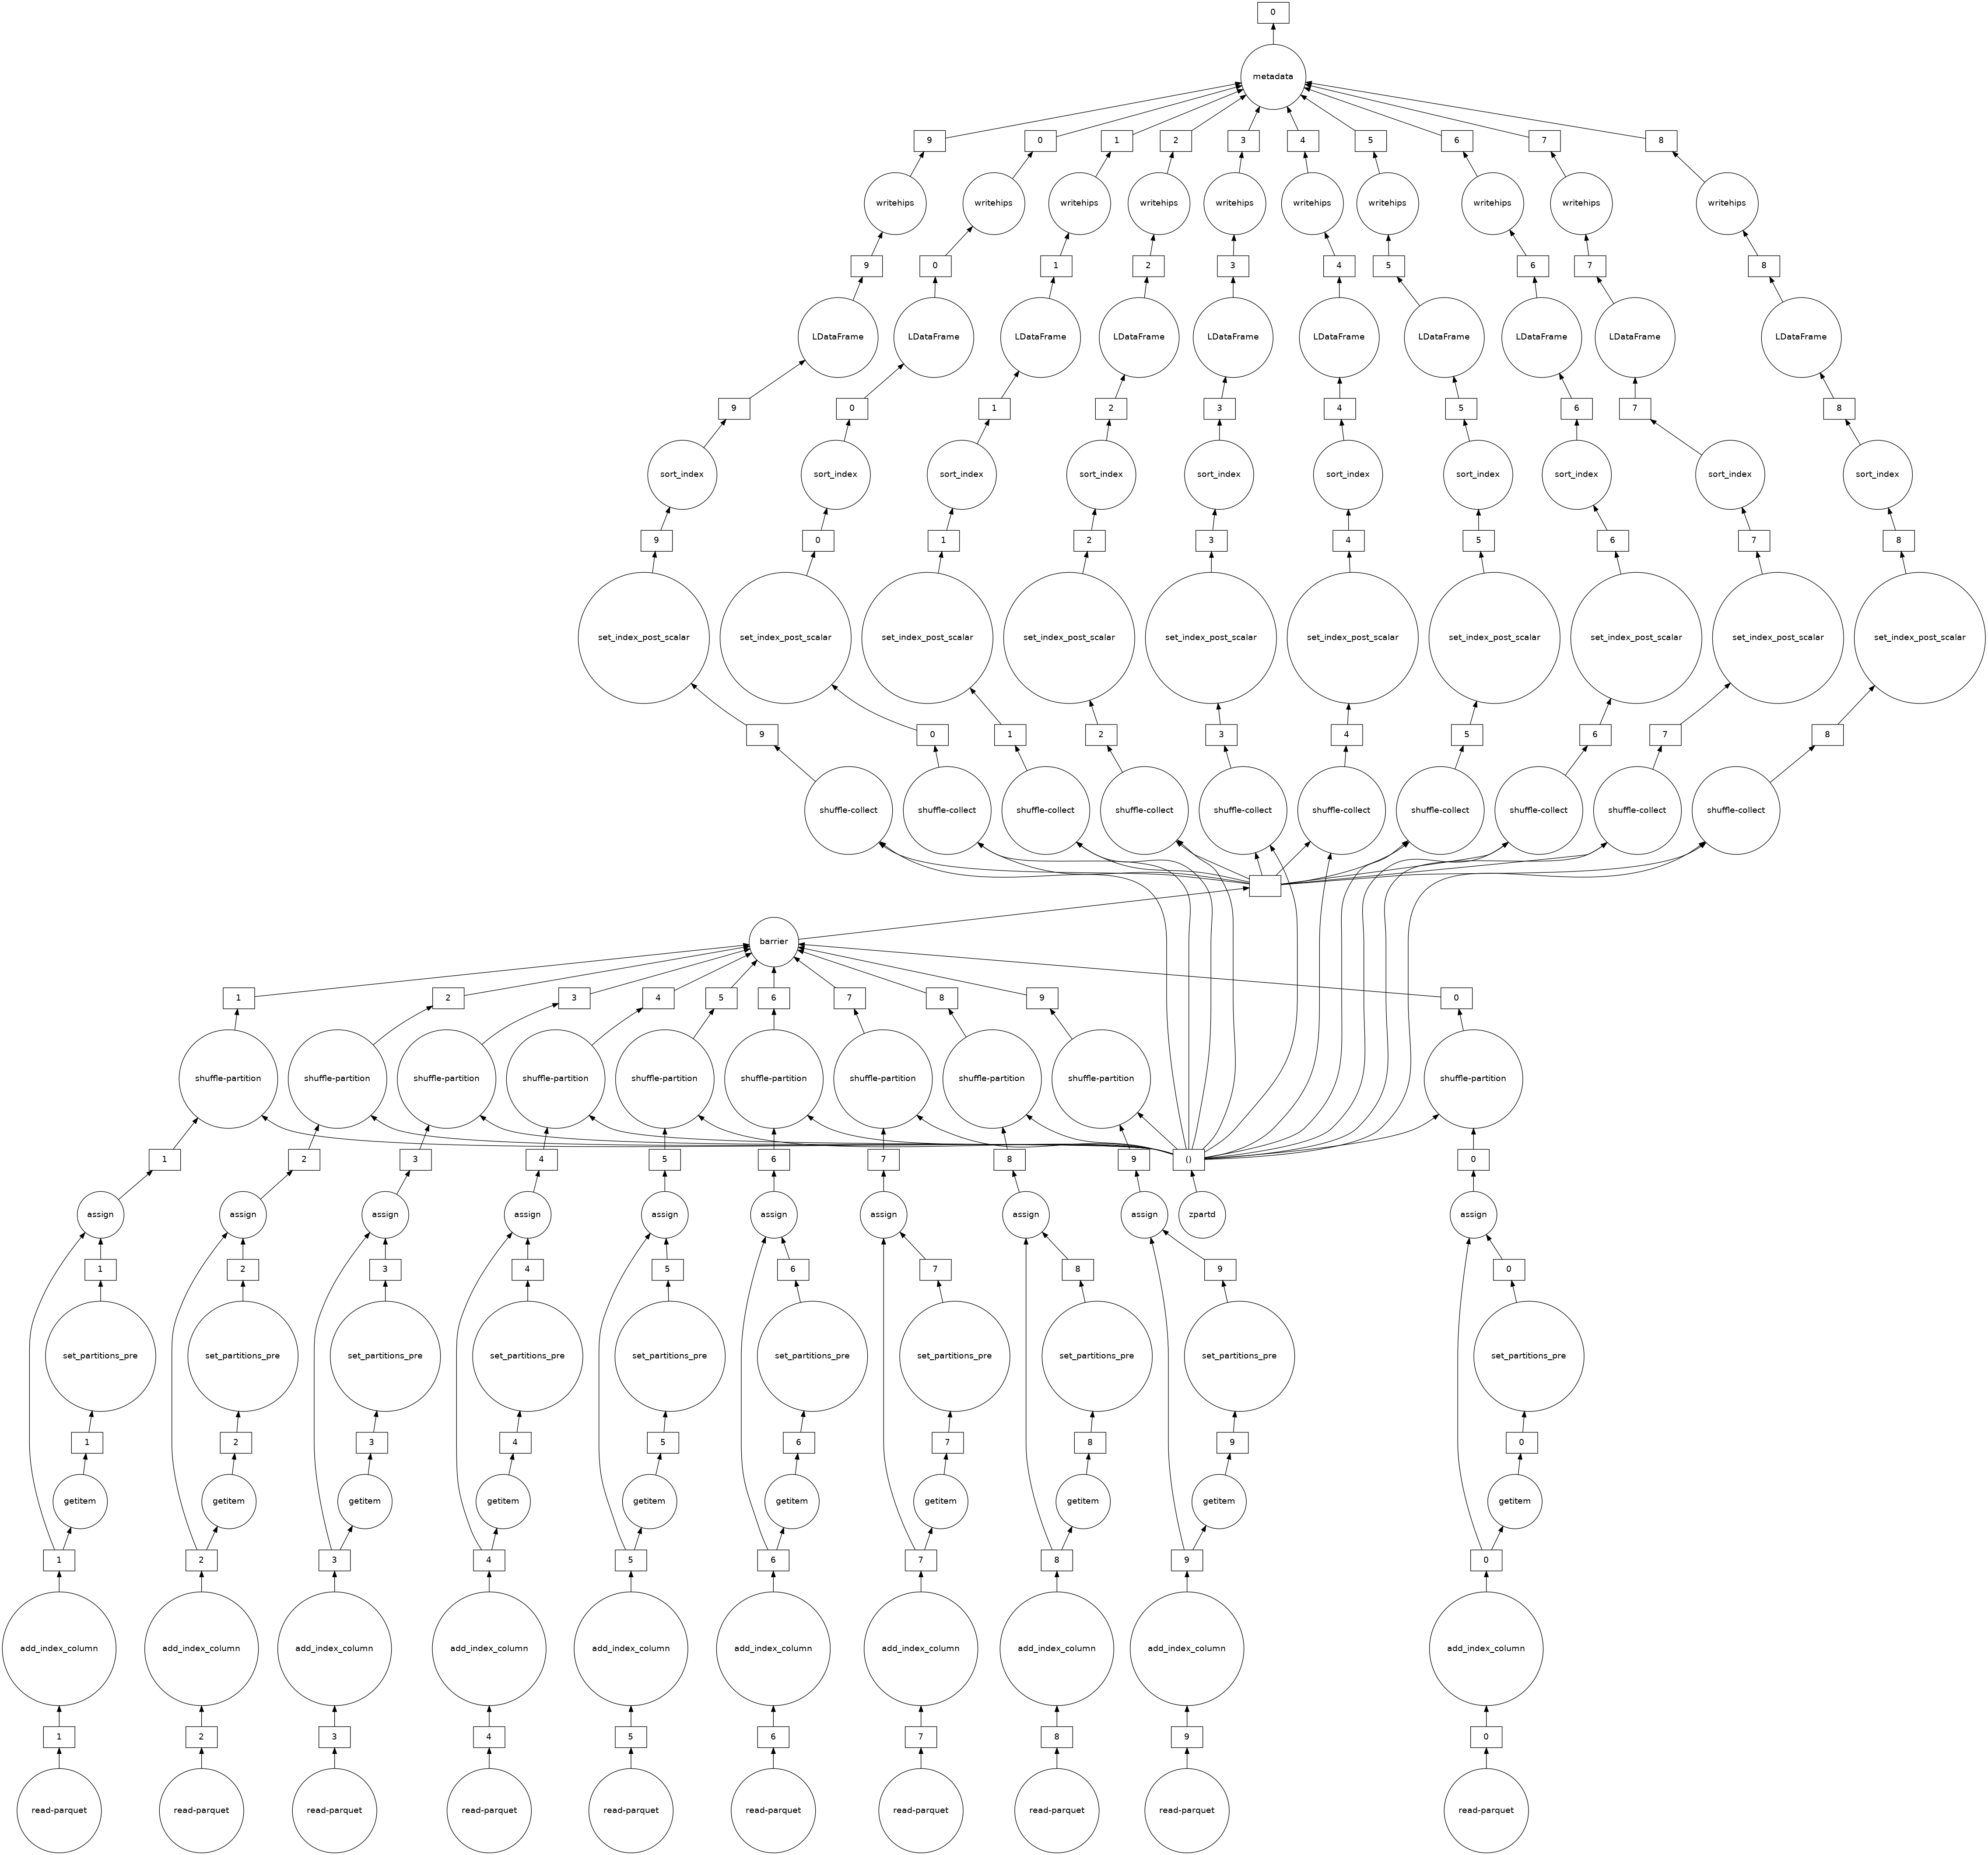

In [28]:
! rm -fr "{outprefix}"

ddf = dd.read_parquet(incat[:10], columns=["ra", "dec"])
ldf = lsdb.from_dask_dataframe(ddf, hcmeta)
graph = ldf.to_hipscat(outprefix, compute=False)
graph.visualize()

Now actually execute:

In [31]:
graph.compute()

[########################################] | 100% Completed | 2.43 ss
[########################################] | 100% Completed | 2.53 s


{'opix': {0: [0, 2, 6], 2: [65, 66, 67, 69, 70, 137, 138]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

Now let's test loading from hipscat. First check we can load the metadata:

In [32]:
hc.HCMetadata.from_hipscat("/epyc/projects3/mjuric_hipscat/foo")

{'opix': {0: array([0, 2, 6], dtype=uint64), 2: array([ 65,  66,  67,  69,  70, 137, 138], dtype=uint64)}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

In [33]:
tuple(hcmeta.compute_divisions())

(0,
 2305843009213693952,
 4683743612465315840,
 4755801206503243776,
 4827858800541171712,
 4971973988617027584,
 5044031582654955520,
 6917529027641081856,
 9871890383196127232,
 9943947977234055168,
 18446744073709551615)

Test reading hipscat:

In [34]:
df = lsdb.read_hipscat("/epyc/projects3/mjuric_hipscat/foo", columns=['ra', 'dec'])
print(f"ndivisions={len(df.divisions)}: {df.divisions[:5]} ...")
assert df.divisions and df.divisions[0] is not None
print(len(df))
type(df)

ndivisions=11: (0, 2305843009213693952, 4683743612465315840, 4755801206503243776, 4827858800541171712) ...
[########################################] | 100% Completed | 385.34 ms
[########################################] | 100% Completed | 484.37 ms
6961555


lsdb.core.LSDBDaskDataFrame

Test that Dask Pandas-like operations work:

In [35]:
df[df["ra"] > 10].compute()

[########################################] | 100% Completed | 571.03 ms
[########################################] | 100% Completed | 612.19 ms


,ra,dec
_ID,,
12484345856,44.996155,0.005615
116614234112,45.004978,0.019880
118561439744,45.004320,0.021048
648845197312,44.995037,0.038152
751496593408,44.963896,0.043595
...,...,...
10016004521694593024,11.242555,-30.073218
10016004568852201472,11.262679,-30.064526
10016004596576550912,11.263623,-30.060752


## Test the usability of LSDBDaskDataFrame objects

In [8]:
type(ldf[["ra"]])

NameError: name 'ldf' is not defined

Why doesn't this return a LSDBDaskDataFrame?

In [37]:
type(ldf.query("ra > 100"))

dask.dataframe.core.DataFrame

## Demo

In [38]:
# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')[:10]
ddf = dd.read_parquet(incat, columns=["ra", "dec"])
m = lsdb.compute_skymap(ddf)
opix, orders = hc.compute_partitioning(m)
hcmeta = hc.HCMetadata.from_skymap(m)

# Create and write the full catalog
! rm -fr "{outprefix}"

ddf = dd.read_parquet(incat)
ldf = lsdb.from_dask_dataframe(ddf, hcmeta)
ldf.to_hipscat(outprefix)

[########################################] | 100% Completed | 600.62 ms
[########################################] | 100% Completed | 674.00 ms
[0, 2305843009213693952, 4683743612465315840, 4755801206503243776, 4827858800541171712, 4971973988617027584, 5044031582654955520, 6917529027641081856, 9871890383196127232, 9943947977234055168, 18446744073709551615]
[########################################] | 100% Completed | 118.72 s
[########################################] | 100% Completed | 118.82 s


{'opix': {0: [0, 2, 6], 2: [65, 66, 67, 69, 70, 137, 138]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

In [31]:
! du -kh /epyc/projects3/mjuric_hipscat/foo

369M	/epyc/projects3/mjuric_hipscat/foo/Norder0/Npix0
397M	/epyc/projects3/mjuric_hipscat/foo/Norder0/Npix2
283M	/epyc/projects3/mjuric_hipscat/foo/Norder0/Npix6
1.1G	/epyc/projects3/mjuric_hipscat/foo/Norder0
328M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix65
395M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix66
322M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix69
339M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix67
333M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix70
374M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix138
355M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix137
2.4G	/epyc/projects3/mjuric_hipscat/foo/Norder2
3.5G	/epyc/projects3/mjuric_hipscat/foo


## The kind of Construction API I've been aiming for...

Ideally, I'd really like this:

In [ ]:
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')
ddf = dd.read_parquet(incat)

ldf = from_dask_dataframe(ddf, ra_col="ra", dec_col="dec", threshold=1_000_000)
ldf.to_hipscat("/epyc/projects3/mjuric_hipscat/foo")

but can't quite figure out yet how to pack all of this into a single task graph...

This is where I am right now:

In [ ]:
# General note: the data source should _always_ be a DaskDataFrame.

# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')
ddf = dd.read_parquet(incat, columns=["ra", "dec"])
partitioning = create_partitioning(ddf)

# Create and write the full catalog
ddf = dd.read_parquet(incat)
ldf = from_dask_dataframe(ddf, partitioning)
ldf.to_hipscat("/epyc/projects3/mjuric_hipscat/foo")

## Load big BZIP files

In [15]:
%%time
neowisercsv = "/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2002.csv.bz2"

ddf = pd.read_csv(neowisercsv, comment="#", skiprows=1_000_000, nrows=1_000_000, delimiter='|',
                 names = "SOURCE_ID,FRAME_NUM,SCAN_ID,SRC,RA,DEC,SIGRA,SIGDEC,SIGRADEC,GLON,GLAT,ELON,ELAT,W1X,W1Y,W2X,W2Y,W1SKY,W1SIGSK,W1CONF,W2SKY,W2SIGSK,W2CONF,W1FITR,W2FITR,W1SNR,W2SNR,W1FLUX,W1SIGFLUX,W2FLUX,W2SIGFLUX,W1MPRO,W1SIGMPRO,W1RCHI2,W2MPRO,W2SIGMPRO,W2RCHI2,RCHI2,NB,NA,W1FRTR,W2FRTR,W1SAT,W2SAT,SATNUM,W1MAG,W1SIGM,W1FLG,W1MCOR,W2MAG,W2SIGM,W2FLG,W2MCOR,W1MAG_1,W1SIGM_1,W1FLG_1,W2MAG_1,W2SIGM_1,W2FLG_1,W1MAG_2,W1SIGM_2,W1FLG_2,W2MAG_2,W2SIGM_2,W2FLG_2,W1MAG_3,W1SIGM_3,W1FLG_3,W2MAG_3,W2SIGM_3,W2FLG_3,W1MAG_4,W1SIGM_4,W1FLG_4,W2MAG_4,W2SIGM_4,W2FLG_4,W1MAG_5,W1SIGM_5,W1FLG_5,W2MAG_5,W2SIGM_5,W2FLG_5,W1MAG_6,W1SIGM_6,W1FLG_6,W2MAG_6,W2SIGM_6,W2FLG_6,W1MAG_7,W1SIGM_7,W1FLG_7,W2MAG_7,W2SIGM_7,W2FLG_7,W1MAG_8,W1SIGM_8,W1FLG_8,W2MAG_8,W2SIGM_8,W2FLG_8,XSCPROX,W1CC_MAP,W1CC_MAP_STR,W2CC_MAP,W2CC_MAP_STR,CC_FLAGS,QUAL_FRAME,QI_FACT,SAA_SEP,MOON_MASKED,DET_BIT,PH_QUAL,SSO_FLG,TMASS_KEY,R_2MASS,PA_2MASS,N_2MASS,J_M_2MASS,J_MSIG_2MASS,H_M_2MASS,H_MSIG_2MASS,K_M_2MASS,K_MSIG_2MASS,ALLWISE_CNTR,R_ALLWISE,PA_ALLWISE,N_ALLWISE,W1MPRO_ALLWISE,W1SIGMPRO_ALLWISE,W2MPRO_ALLWISE,W2SIGMPRO_ALLWISE,W3MPRO_ALLWISE,W3SIGMPRO_ALLWISE,W4MPRO_ALLWISE,W4SIGMPRO_ALLWISE,MJD,CNTR,X,Y,Z,SPT_IND,HTM20".split(',')
                 )


CPU times: user 1min 31s, sys: 4.08 s, total: 1min 35s
Wall time: 1min 36s


In [22]:
pd.set_option('display.max_columns', None)

In [8]:
def split_bzip(fn, schema, outprefix, nrows=1_000_000):
    import bz2, io
    import os.path

    tmap = dict(i2='Int16', i4='Int32', i8='Int64')
    schema = dict( (k, tmap.get(v, v)) for k, v in schema.items()) 

    with bz2.open(fn) as fp:
        k = 0
        done = False
        while not done:
            csv = io.BytesIO()
            for _ in range(nrows):
                try:
                    csv.write(next(fp))
                    csv.write(b"\n")
                except StopIteration:
                    done = True
                    break

            csv.seek(0)
            df = pd.read_csv(csv, comment="#",
                             delimiter="|",
                             dtype=schema,
                             names=schema.keys()
                            )

            outfn = os.path.join(outprefix, os.path.basename(f"{fn}.{k:05d}.parquet"))
            df.to_parquet(outfn)

            print(outfn[-50:])
            k +=1

    return (fn, k) #df

#fn="/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2029.csv.bz2"
#df = split_bzip(fn, schema, outprefix, nrows=1_000_000)
#df

In [8]:
outprefix

'/epyc/projects3/mjuric_hipscat/foo'

In [106]:
%%time
def csv_to_parquet_chunks(fn, schema, outprefix, chunksize=1_000_000, nchunks=None, **kwargs):
    import bz2, os.path

    # convert schema to nullable types, while working around the loss-of-precision
    # but in Pandas (https://github.com/pandas-dev/pandas/issues/32134).
    tmap = dict(i2='Int16', i4='Int32', i8='Int64') # map dtypes to their nullable Pandas equivalents
    schemaRaw  = dict( (k, "a20" if v in tmap else v) for k, v in schema.items()) 
    #schemaNull = dict( (k, tmap.get(v, v)) for k, v in schema.items()) 

    # use string[pyarrow] type to store strings
    # 2-4x more memory efficient than Python strings (same speed, though). Valid for pandas 1.5.3
    schemaRaw = dict( (k, "string[pyarrow]" if v.startswith("a") else v) for k, v in schemaRaw.items()) 
#    print(schemaRaw.values())

    for k, df in enumerate(pd.read_csv(fn, comment="#",
                        delimiter="|",
                        dtype=schemaRaw,
                        names=schema.keys(),
                        iterator=True,
                        chunksize=chunksize
                                      )):

        # convert nullable types in a way that doesn't trigger
        # pandas:issues/31234. we do this by loading int columns as bytes,
        # recording the locations with NULLs, filling them w. dummy data
        # converting, then re-setting manually to NULLs
        for name, type_ in schema.items():
            if type_ not in tmap:
                continue
            mask = df[name].isnull().values
            df[name][mask] = '0'
            df[name] = df[name].astype(type_).convert_dtypes()
            df[name][mask] = pd.NA

        # write the output
        outfn = os.path.join(outprefix, os.path.basename(f"{fn}.{k:05d}.parquet"))
        df.to_parquet(outfn, **kwargs)
        
        if k+1 == nchunks:
            break

    return (fn, k)

if True:
    schemaFn = "schema.txt"
    with open(schemaFn) as fp:
        schema = dict(tuple(line.split()) for line in fp)

    outprefix = "/epyc/data3/NEOWISE-yr8/parquet"
    fn="/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2004.csv.bz2"
    df = csv_to_parquet_chunks(fn, schema, outprefix, chunksize=1_000_000, nchunks=1)
    df

CPU times: user 1min 40s, sys: 22.7 s, total: 2min 3s
Wall time: 1min 26s


None: 234 (4.14 read) | snappy: 208MB (4.3s read) | brotli: 175 (5.5s read) | gzip: 185MB (5.6s read)

In [66]:
df[["ALLWISE_CNTR"]]

TypeError: tuple indices must be integers or slices, not list

In [107]:
%%time
# seems that string[pyarrow] makes the read ~30% faster and using ~40% less memory
with pd.option_context("string_storage", "pyarrow"):
    df = pd.read_parquet("/epyc/data3/NEOWISE-yr8/parquet/neowiser.neowiser_yr8_p1bs_psd.LOAD_2004.csv.bz2.00000.parquet")
    df.groupby("ALLWISE_CNTR").count().sort_values("RA")
print(df.memory_usage(deep=True).sum())

686572923
CPU times: user 4.23 s, sys: 2.05 s, total: 6.29 s
Wall time: 4.13 s


In [83]:
df.memory_usage(deep=True).sum()

682572923

In [105]:
pd.set_option('display.max_columns', None)
df

,SOURCE_ID,FRAME_NUM,SCAN_ID,SRC,RA,DEC,SIGRA,SIGDEC,SIGRADEC,GLON,GLAT,ELON,ELAT,W1X,W1Y,W2X,W2Y,W1SKY,W1SIGSK,W1CONF,W2SKY,W2SIGSK,W2CONF,W1FITR,W2FITR,W1SNR,W2SNR,W1FLUX,W1SIGFLUX,W2FLUX,W2SIGFLUX,W1MPRO,W1SIGMPRO,W1RCHI2,W2MPRO,W2SIGMPRO,W2RCHI2,RCHI2,NB,NA,W1FRTR,W2FRTR,W1SAT,W2SAT,SATNUM,W1MAG,W1SIGM,W1FLG,W1MCOR,W2MAG,W2SIGM,W2FLG,W2MCOR,W1MAG_1,W1SIGM_1,W1FLG_1,W2MAG_1,W2SIGM_1,W2FLG_1,W1MAG_2,W1SIGM_2,W1FLG_2,W2MAG_2,W2SIGM_2,W2FLG_2,W1MAG_3,W1SIGM_3,W1FLG_3,W2MAG_3,W2SIGM_3,W2FLG_3,W1MAG_4,W1SIGM_4,W1FLG_4,W2MAG_4,W2SIGM_4,W2FLG_4,W1MAG_5,W1SIGM_5,W1FLG_5,W2MAG_5,W2SIGM_5,W2FLG_5,W1MAG_6,W1SIGM_6,W1FLG_6,W2MAG_6,W2SIGM_6,W2FLG_6,W1MAG_7,W1SIGM_7,W1FLG_7,W2MAG_7,W2SIGM_7,W2FLG_7,W1MAG_8,W1SIGM_8,W1FLG_8,W2MAG_8,W2SIGM_8,W2FLG_8,XSCPROX,W1CC_MAP,W1CC_MAP_STR,W2CC_MAP,W2CC_MAP_STR,CC_FLAGS,QUAL_FRAME,QI_FACT,SAA_SEP,MOON_MASKED,DET_BIT,PH_QUAL,SSO_FLG,TMASS_KEY,R_2MASS,PA_2MASS,N_2MASS,J_M_2MASS,J_MSIG_2MASS,H_M_2MASS,H_MSIG_2MASS,K_M_2MASS,K_MSIG_2MASS,ALLWISE_CNTR,R_ALLWISE,PA_ALLWISE,N_ALLWISE,W1MPRO_ALLWISE,W1SIGMPRO_ALLWISE,W2MPRO_ALLWISE,W2SIGMPRO_ALLWISE,W3MPRO_ALLWISE,W3SIGMPRO_ALLWISE,W4MPRO_ALLWISE,W4SIGMPRO_ALLWISE,MJD,CNTR,X,Y,Z,SPT_IND,HTM20
0,24059r004-007276,4,24059r,7276,80.510715,-63.782017,0.8984,0.7842,0.1392,273.419119,-33.957444,30.517019,-85.150086,150.871994,496.535004,152.945999,497.468994,15.377,4.171,0.0,40.024,4.953,0.0,7.5,7.5,4.4,0.4,73.188004,16.500999,7.323500,19.705999,16.100000,0.245,0.9919,15.469,NaN,0.6238,0.7746,1,0,0000,0000,0.0,0.0,0000,16.326000,0.486,0,0.26,14.615,NaN,32,0.326,16.910999,0.474,0,15.322,NaN,32,16.586000,0.486,0,14.941,NaN,32,15.700000,NaN,32,14.217,NaN,32,15.454,NaN,32,13.639,NaN,32,15.049,NaN,32,13.248,NaN,32,15.125,0.363,3,13.262,NaN,32,14.420,0.215,3,13.155,NaN,32,13.655,0.121,3,11.751,NaN,32,NaN,0.0,<NA>,0.0,<NA>,0000,10,1.0,58.866001,00,1,BU,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,792063701351025501,0.455251,88.199997,1,16.410999,0.038,16.606001,0.102,13.894,NaN,9.727,NaN,59216.506322,2405918004007276,0.072834,0.435742,-0.897120,101123111,9188399531995
1,24059r004-007277,4,24059r,7277,81.518855,-63.725482,0.6242,0.6498,-0.1900,273.290094,-33.521045,34.590429,-85.451331,593.596008,885.169983,594.685974,884.218994,13.513,3.076,0.0,40.644,3.849,0.0,7.5,7.5,5.1,1.6,74.775002,14.536000,40.032001,25.107000,16.077000,0.211,0.9847,14.755,NaN,0.7942,0.8516,1,0,0000,0000,0.0,0.0,0000,15.960000,0.386,1,0.26,14.232,NaN,32,0.326,16.837000,0.463,1,14.908,NaN,32,16.219999,0.386,1,14.558,NaN,32,15.876000,0.368,3,14.175,NaN,32,15.737,0.399,3,13.877,NaN,32,15.616,0.434,3,13.714,NaN,32,15.360,0.445,3,13.520,NaN,32,14.997,0.424,3,13.289,NaN,32,14.595,0.357,3,13.034,NaN,32,NaN,0.0,<NA>,0.0,<NA>,0000,10,1.0,58.866001,00,1,BU,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59216.506322,2405918004007277,0.065287,0.437832,-0.896683,101123303,9190378038442
2,24059r004-007278,4,24059r,7278,81.187856,-63.379257,0.7487,0.7062,-0.1746,272.895665,-33.704636,36.419834,-85.106420,805.114014,439.514008,802.989990,437.576996,12.361,3.118,0.0,40.163,5.295,0.0,7.5,7.5,4.6,2.1,70.056999,15.190000,52.490002,25.502001,16.146999,0.235,1.2470,15.343,0.527,0.2507,0.7487,1,0,0000,0000,0.0,0.0,0000,15.783000,NaN,32,0.26,13.943,NaN,32,0.326,16.368000,NaN,32,14.556,NaN,32,16.042999,NaN,32,14.269,NaN,32,15.839000,NaN,32,13.971,NaN,32,15.702,NaN,32,13.805,NaN,32,15.576,NaN,32,13.551,NaN,32,15.241,NaN,32,13.349,NaN,32,14.653,NaN,32,13.198,NaN,32,13.928,NaN,32,13.064,NaN,32,NaN,0.0,<NA>,0.0,<NA>,0000,10,1.0,58.866001,00,3,BC,0.0,183820303.0,0.93604,95.099998,1,16.535999,0.1584,15.722,0.1752,16.153999,NaN,825063701351043706,0.914831,120.900002,1,15.985000,0.034,16.375000,0.093,13.701,NaN,9.737,NaN,59216.506322,2405918004007278,0.068644,0.442794,-0.893992,101123302,9190336710791
3,24059r004-007279,4,24059r,7279,80.137766,-63.621423,1.0347,0.8823,-0.2457,273.251797,-34.141488,30.738490,-84.920468,161.727005,194.304001,162.468002,195.197998,13.411,3.305,0.0,39.676,4.023,0.

In [47]:
with pd.option_context('display.max_rows', None,):
    print(df.dtypes)

SOURCE_ID             object
FRAME_NUM              Int16
SCAN_ID               object
SRC                    Int32
RA                   float64
DEC                  float64
SIGRA                float32
SIGDEC               float32
SIGRADEC             float32
GLON                 float64
GLAT                 float64
ELON                 float64
ELAT                 float64
W1X                  float32
W1Y                  float32
W2X                  float32
W2Y                  float32
W1SKY                float64
W1SIGSK              float32
W1CONF               float64
W2SKY                float64
W2SIGSK              float32
W2CONF               float64
W1FITR               float32
W2FITR               float32
W1SNR                float32
W2SNR                float32
W1FLUX               float32
W1SIGFLUX            float32
W2FLUX               float32
W2SIGFLUX            float32
W1MPRO               float32
W1SIGMPRO            float32
W1RCHI2              float32
W2MPRO        

In [48]:
with pd.option_context('display.max_rows', None,):
    with pd.option_context('display.float_format', '{:0.20f}'.format):
        print(df.iloc[0])

SOURCE_ID                  b'24059r004-007276'
FRAME_NUM                                    4
SCAN_ID                              b'24059r'
SRC                                       7276
RA                     80.51071460000000001855
DEC                   -63.78201700000000329283
SIGRA                   0.89840000867843627930
SIGDEC                  0.78420001268386840820
SIGRADEC                0.13920000195503234863
GLON                  273.41911920000001146036
GLAT                  -33.95744429999999880465
ELON                   30.51701939999999879660
ELAT                  -85.15008629999999811844
W1X                   150.87199401855468750000
W1Y                   496.53500366210937500000
W2X                   152.94599914550781250000
W2Y                   497.46899414062500000000
W1SKY                  15.37700000000000066791
W1SIGSK                 4.17100000381469726562
W1CONF                  0.00000000000000000000
W2SKY                  40.02400000000000090949
W2SIGSK      

In [109]:
%%time

schemaFn = "schema.txt"
with open(schemaFn) as fp:
    schema = dict(tuple(line.split()) for line in fp)

neowisercsv = glob.glob("/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.*.csv.bz2")
outprefix = "/epyc/data3/NEOWISE-yr8/parquet"

import dask.bag as db
outputs = ( db
     .from_sequence(neowisercsv)
     .map(lambda fn: csv_to_parquet_chunks(fn, schema, outprefix))
     .compute()
)

outputs

CPU times: user 7h 35min 44s, sys: 5h 40min 48s, total: 13h 16min 33s
Wall time: 18h 13min 45s


[('/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2001.csv.bz2',
  247),
 ('/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2004.csv.bz2',
  218),
 ('/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2000.csv.bz2',
  215),
 ('/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2003.csv.bz2',
  245),
 ('/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2005.csv.bz2',
  225),
 ('/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2002.csv.bz2',
  225),
 ('/epyc/data3/NEOWISE-yr8/irsa.ipac.caltech.edu/data/download/neowiser_year8/neowiser.neowiser_yr8_p1bs_psd.LOAD_2006.csv.bz2',
  252),
 ('/epyc/data3/NEOWISE-yr8/irsa.ipac.calt